In [224]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import Angle

from image_code import image_calculation_functions as ic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
theta_p = 181
phi_p = 361
phi = np.linspace(-180,180,phi_p)*np.pi/180
theta = np.linspace(0,90,int(theta_p/2)+1)*np.pi/180
P,T = np.meshgrid(phi,theta)


In [12]:
far_array=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_nooffset.npy')

In [11]:

beam_squarel,ethetal, ephil=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-0',31,theta_p,phi_p)
beam_squarel90,ethetal90,ephil90=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-90',31,theta_p,phi_p)

beam_squareh,ethetah, ephih = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith',10,theta_p,phi_p)
beam_squareh90,ethetah90,ephih90 = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith-90',10,theta_p,phi_p)


In [ ]:

sample = 1

    
if sample==0:
    wav = 500 #in m; f = 0.6 MHz
    index = 17
    freq = '0p6_MHz'
    beam_square,etheta, ephi = beam_squarel,ethetal, ephil
    beam_square90,etheta90,ephi90 = beam_squarel90,ethetal90,ephil90
    factor =150
    
elif sample==1:
    wav = 150 # in m; f = 2MHz
    index = 3
    freq = '2_MHz'
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    factor =500

elif sample==2:
    wav = 30 # in m; f = 10MHz
    index = 4
    freq = '10_MHz'
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    factor =2500
    
f = 300/wav

l_grid = np.linspace(-1,1,int(factor))
m_grid = l_grid
L,M = np.meshgrid(l_grid,m_grid)

q = L**2+M**2
el = np.sqrt(1 - q)
el[q>=1] = 0
p =-np.arctan2(M,L) 
t = np.pi/2 - np.arcsin(el)#-np.arcsin(L,(np.sin(p)))+np.pi/2

etheta = np.roll(etheta[:,:,:-1],180,axis=2)/np.max(etheta[index,:,:])
etheta90 = np.roll(etheta90[:,:,:-1],180,axis=2)/np.max(etheta90[index,:,:])
ephi = np.roll(ephi[:,:,:-1],180,axis=2)/np.max(ephi[index,:,:])
ephi90 = np.roll(ephi90[:,:,:-1],180,axis=2)/np.max(ephi90[index,:,:])







In [14]:
etheta[index,0,:]=0
etheta90[index,0,:]=0
ephi[index,0,:]=0
ephi90[index,0,:]=0

In [17]:
beam_etheta = ic.beam_interpolate(etheta[index],theta,phi[:-1],t,p)
beam_etheta90 = ic.beam_interpolate(etheta90[index],theta,phi[:-1],t,p)

beam_ephi = ic.beam_interpolate(ephi[index],theta,phi[:-1],t,p)
beam_ephi90 = ic.beam_interpolate(ephi90[index],theta,phi[:-1],t,p)



In [38]:
cygA_ra = Angle('19 59 28.35645829',unit=u.hourangle)
cygA_dec = Angle('+40 44 02.0966496', unit=u.degree)

casA_ra = Angle('23 23 24.000',unit=u.hourangle)
casA_dec = Angle('+58 48 54.00', unit=u.degree)

tauA_ra = Angle('05 34 31.94',unit=u.hourangle)
tauA_dec = Angle('+22 00 52.2', unit=u.degree)

sgrA_ra = Angle('17 45 40.03599',unit=u.hourangle)
sgrA_dec = Angle('-29 00 28.1699', unit=u.degree)

ra_list = [cygA_ra, casA_ra, tauA_ra, sgrA_ra]
dec_list = [cygA_dec, casA_dec, tauA_dec, sgrA_dec]
flux_list = [13500, 10000, 28000, 10000]

In [125]:
off = np.linspace(-12,12,24)*u.hour
cyg_a_altaz = np.zeros((len(off),2))
cyg_A = ic.processed_source()



for i in range(len(off)):
    cyg_A.init_skycoord('19 59 28.35645829 +40 44 02.0966496', Time.now()+off[i])
    cyg_a_altaz[i] = cyg_A.obj_a_altaz
    
s_index = np.where(cyg_a_altaz == np.max(cyg_a_altaz[:,0]))[0]
time = Time.now()+off[10]


In [126]:
t2 = Time(time, scale='utc',location=('180d', '0d'))
lst = t2.sidereal_time('apparent').value
print(t2,lst)

2022-03-09 22:00:11.401924 21.174377942973223


In [127]:
sky_obj = ic.processed_source()
sky_obj.init_skycoords(ra_list,dec_list,flux_list,time)

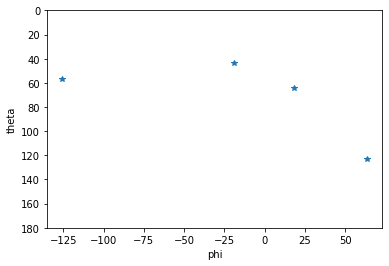

In [128]:
sky_obj.plot_skymap()

In [129]:
sky_obj.tp_to_lm(90,l_grid,m_grid)


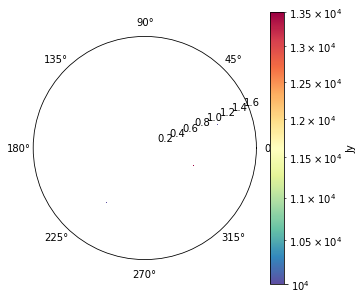

In [146]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,sky_obj.sky_map,cmap='Spectral_r',norm= LogNorm())#vmin=-10, vmax =1000)
ax.set_ylim([0,95*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

In [132]:
sky_obj.calculate_delphi(50,wav,L,M)

In [133]:
J = np.array([[beam_etheta,beam_ephi] ,[beam_etheta90,beam_ephi90]])



In [134]:
sky_obj.make_sky_coherence()
sky_obj.make_offset_jacob(J)

In [135]:
sky_obj.make_pseudo_vis(J)

In [136]:
sky_obj.invert_offset_jacob()
sky_obj.offset_ft()

In [138]:
sky_obj.uvcal(wav,far_array)

In [139]:
sky_obj.make_dirty_image(off_c=0)
corrected=ic.offset_correction(sky_obj.J_in,sky_obj.image_off)

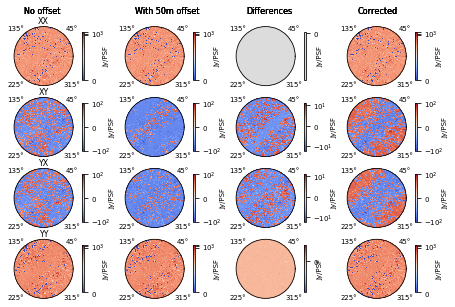

In [239]:

final = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_off = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)
final_offc = np.zeros((4,np.shape(sky_obj.beam_ft)[2],np.shape(sky_obj.beam_ft)[3]),dtype = np.complex128)

fig,ax = plt.subplots(4,4, subplot_kw=dict(polar=True),figsize=(7.5,5))
plt.subplots_adjust(wspace=0.3,hspace=0.2)
text = ['XX','XY','YX','YY']
plt.rc('font',size=7)
plt.rc('axes', labelsize=7)

c=0
for i in range(2):
    for j in range(2):
        final[c] = sky_obj.image[i,j] 
        final_off[c] = sky_obj.image_off[i,j]
        final_offc[c] = corrected[i,j]
        c=c+1
ticks = [[0,500,1000,1500], [-100,0, 100], [-100,0,100], [0,500,1000,1500]]           
ticks2 = [[-1,0,1], [-10,0,10], [-10,0,10], [-1,0,1]]
for i in range(4):
           
    
    #fig.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)  
    
    p1 =ax[int(i%4),0].pcolormesh(p,t,np.real(final[i]),cmap='coolwarm',norm = SymLogNorm(linthresh=1e-4),vmin=ticks[i][0], vmax = ticks[i][-1])  
    cbar = plt.colorbar(p1, ax=ax[int(i%4),0],pad = 0.1, shrink = 0.8,ticks = ticks[int(i%4)])
    cbar.set_label(label='Jy/PSF',labelpad =-1.5)
    ax[int(i%4),0].set_yticklabels([])
    ax[int(i%4),0].set_title(text[i],pad=0.0, fontsize = 8)
    ax[int(i%4),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),0].tick_params(axis='x',pad=-0.5)
    ax[0,0].text(2,2.5,'No offset', fontsize=8)
    
    p1 =ax[int(i%4),1].pcolormesh(p,t,np.real(final_off[i]),cmap='coolwarm',norm = SymLogNorm(linthresh=1e-4),vmin=ticks[i][0], vmax = ticks[i][-1])
    cbar = plt.colorbar(p1, ax=ax[int(i%4),1],pad = 0.1, shrink = 0.8,ticks = ticks[int(i%4)])
    cbar.set_label(label='Jy/PSF',labelpad =-1.5)
    ax[int(i%4),1].set_yticklabels([])
    ax[int(i%4),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),1].tick_params(axis='x',pad=-0.5)
    ax[0,1].text(2,2.5,'With 50m offset', fontsize=8)
    
    p1 =ax[int(i%4),3].pcolormesh(p,t,(np.real(final_offc[i])),cmap='coolwarm',norm = SymLogNorm(linthresh=1e-4),vmin=ticks[i][0], vmax = ticks[i][-1])  
    cbar = plt.colorbar(p1, ax=ax[int(i%4),3],pad = 0.1, shrink = 0.8,ticks = ticks[int(i%4)])
    cbar.set_label(label='Jy/PSF',labelpad =-1.5)
    ax[int(i%4),3].set_yticklabels([])
    ax[int(i%4),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),3].tick_params(axis='x',pad=-0.5)
    ax[0,3].text(2,2.5,'Corrected', fontsize=8)
    
    
    p1 =ax[int(i%4),2].pcolormesh(p,t,(np.real(final_off[i])- np.real(final[i])),cmap='coolwarm',norm = SymLogNorm(linthresh=1e-4))#,vmin=-1, vmax = 1)  
    cbar = plt.colorbar(p1, ax=ax[int(i%4),2],pad = 0.1, shrink = 0.8,ticks = ticks2[int(i%4)])
    cbar.set_label(label='Jy/PSF',labelpad =-1.5)
    ax[int(i%4),2].set_yticklabels([])
    ax[int(i%4),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax[int(i%4),2].tick_params(axis='x',pad=-0.5)
    ax[0,2].text(2,2.5,'Differences', fontsize=8)
   
plt.savefig('/data4/nmahesh/edges/Lunar/plot_stokes_image_XX-YX_Ateam_off_nooff_2mhz_real.png',dpi=200,bbox_inches='tight')




In [142]:
sky_pol = ic.beamtopol(final)
sky_pol_off = ic.beamtopol(final_off)
sky_pol_offc = ic.beamtopol(final_offc)

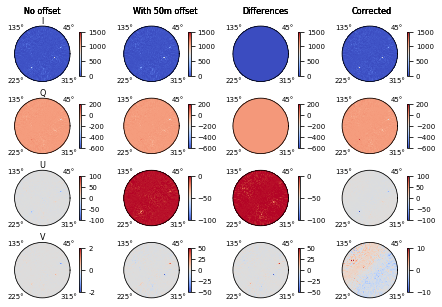

In [196]:


text = ['I', 'Q', 'U', 'V']
fig2,ax2 = plt.subplots(4,4, subplot_kw=dict(polar=True),figsize=(7.5,5))
plt.subplots_adjust(hspace=0.3,wspace=0.2)
plt.rc('font',size=7)
plt.rc('axes', labelsize=7)
ticks = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0,50,100], [-2,0,2]]
ticks2 = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0,50,100], [-10,0,10]]
ticks3 = [[0,500,1000,1500], [-600,-400,-200,0, 200], [-100,-50,0], [-50,-25, 0,25,50]]
for i in range(4):
    p2 = ax2[int(i%4),0].pcolormesh(p,t,np.real(sky_pol[i]),cmap='coolwarm',vmin=ticks[i][0], vmax = ticks[i][-1])  
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),0], pad = 0.1, shrink = 0.8, ticks = ticks[int(i%4)])
    cbar.ax.set_yticklabels(ticks[i]) 
    ax2[int(i%4),0].set_title(text[i], pad=0.0, fontsize = 8)
    ax2[0,0].text(2,2.5,'No offset', fontsize=8)
    ax2[int(i%4),0].set_yticklabels([])
    ax2[int(i%4),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),0].tick_params(axis='x',pad=-0.5)
    


###########################################################################################

    p2 = ax2[int(i%4),1].pcolormesh(p,t,np.real( sky_pol_off[i]),cmap='coolwarm',vmin=ticks3[i][0], vmax = ticks3[i][-1])  
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),1], pad = 0.1, shrink=0.8, ticks = ticks3[int(i%4)])
    ax2[0,1].text(2,2.5,'With 50m offset', fontsize=8)
    ax2[int(i%4),1].set_yticklabels([])
    ax2[int(i%4),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),1].tick_params(axis='x',pad=-0.5)
   

#########################################################################################
    p2 = ax2[int(i%4),2].pcolormesh(p,t,np.real( sky_pol_off[i]) - np.real(sky_pol[i]),cmap='coolwarm',vmin=ticks3[i][0], vmax = ticks3[i][-1])
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),2],pad = 0.1, shrink = 0.8, ticks = ticks3[int(i%4)])
    ax2[0,2].text(2,2.5,r'Differences', fontsize=8)
    ax2[int(i%4),2].set_yticklabels([])
    ax2[int(i%4),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),2].tick_params(axis='x',pad=-0.5)
    
#########################################################################################
    p2 = ax2[int(i%4),3].pcolormesh(p,t,np.real( sky_pol_offc[i]),cmap='coolwarm',vmin=ticks2[i][0], vmax = ticks2[i][-1])
    cbar = plt.colorbar(p2, ax=ax2[int(i%4),3],pad = 0.1, shrink = 0.8, ticks = ticks2[int(i%4)])
    ax2[0,3].text(2,2.5,r'Corrected', fontsize=8)
    ax2[int(i%4),3].set_yticklabels([])
    ax2[int(i%4),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%4),3].tick_params(axis='x',pad=-0.5,labelsize=7)

    

plt.savefig('plot_stokes_image_stokes_Ateam_off_nooff_correct_2MHz_real.pdf',bbox_inches='tight')


In [ ]:
final = np.zeros((4, np.shape(cas_A.beam_ft)[2],np.shape(cas_A.beam_ft)[3]),dtype = np.complex128)
final_off = np.zeros((4, np.shape(cas_A.beam_ft)[2],np.shape(cas_A.beam_ft)[3]),dtype = np.complex128)
final_offc = np.zeros((4,np.shape(cas_A.beam_ft)[2],np.shape(cas_A.beam_ft)[3]),dtype = np.complex128)

fig,ax = plt.subplots(4,3, subplot_kw=dict(polar=True),figsize=(12,16))
text = ['XX','XY','YX','YY']
c =0
for i in range(2):
    for j in range(2):
           
      
        final[c] = sgr_A.image[i,j] #+ sgr_A.image[i] + cas_A.image[i] +
        final_off[c] =  sgr_A.image_off[i,j] #+ sgr_A.image_off[i] + cas_A.image_off[i] +
        final_offc[c] = corrected_sgr[i,j]#image_f[i,j]
        c = c+1
for i in  range(4):
    fig.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=18,y=0.95)  
    
    p1 =ax[int(i%4),0].pcolormesh(p,t,np.real(final[i]),cmap='Spectral_r')#,norm=LogNorm())    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),0])
    ax[int(i%4),0].set_title(text[i], pad=25, fontsize = 18)
    ax[int(i%4),0].set_rlabel_position(50)
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax[0,0].text(1.75,2.5,'No Offset', fontsize=18)
    
    p1 =ax[int(i%4),1].pcolormesh(p,t,np.real( final_off[i]),cmap='Spectral_r')    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),1])
    ax[int(i%4),1].set_rlabel_position(50)
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax[0,1].text(1.75,2.5,'No offset - 50m offset', fontsize=18)
    
    p1 =ax[int(i%4),2].pcolormesh(p,t,np.real( final_offc[i]),cmap='Spectral_r')    #,vmin=0, vmax = 0.0005)  
    plt.colorbar(p1, ax=ax[int(i%4),2])
    ax[int(i%4),2].set_rlabel_position(50)
    plt.ylabel('theta(deg)')
    plt.xlabel('phi(deg)')
    ax[0,2].text(1.75,2.5,r'No offset - Corrected ', fontsize=18)
    
    


